In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
classes = [
    "camera_interaction",
    "climbing_down",
    "climbing_up",
    "hanging",
    "running",
    "sitting",
    "sitting_on_back",
    "standing",
    "walking",
]

In [110]:
results = [
    "i3d_val_results.npz",
    "mvit_val_results.npz",
    "x3d_val_results.npz",
    "r50_val_results.npz",
]

In [111]:
logits = np.array([])
labels = np.array([])

for result in results:
    data = np.load(result)
    logits = np.concatenate((logits, [np.argmax(e) for e in data["logits"]]))
    labels = np.concatenate((labels, data["labels"]))

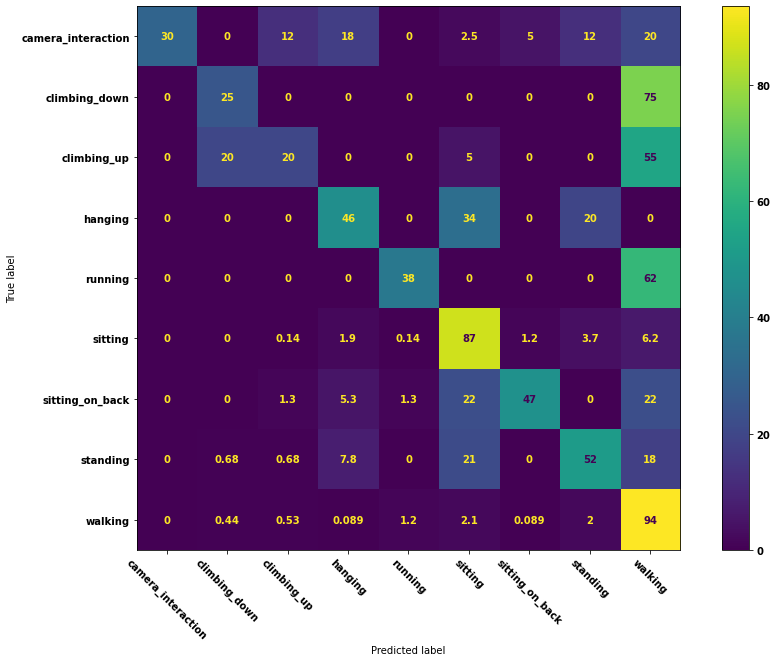

In [115]:
font = {"family": "normal", "weight": "bold", "size": 10}
plt.rc("font", **font)

cm = confusion_matrix(labels, logits)
cm = cm / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(15, 10))
disp.plot(ax=ax)
plt.xticks(rotation=-45)  # Rotates X-Axis Ticks by 45-degrees
plt.savefig("p500_confusion_matrix.pdf", dpi=300)

In [104]:
r = {}
for cls, y in enumerate(cm):
    r[classes[cls]] = {}
    for j, p in enumerate(y):
        if j != cls:
            if p > 0:
                r[classes[cls]][classes[j]] = p

In [105]:
# sort nested dict by value
r = {
    k: {k2: v2 for k2, v2 in sorted(v.items(), key=lambda item: item[1], reverse=True)}
    for k, v in r.items()
}

In [10]:
df = pd.DataFrame(r).transpose()
df["total"] = df.sum(axis=1)

In [11]:
df

,walking,standing,sitting,hanging,climbing_up,running,climbing_down,sitting_on_back,camera_interaction,total
camera_interaction,44.0,16.0,10.0,7.0,2.0,NaN,NaN,NaN,NaN,79.0
climbing_down,8.0,1.0,5.0,NaN,5.0,1.0,NaN,NaN,NaN,20.0
climbing_up,19.0,1.0,6.0,4.0,NaN,1.0,13.0,1.0,NaN,45.0
hanging,12.0,75.0,81.0,NaN,7.0,NaN,4.0,NaN,NaN,179.0
running,98.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,99.0
sitting,57.0,94.0,NaN,91.0,2.0,NaN,1.0,6.0,7.0,258.0
sitting_on_back,5.0,NaN,6.0,1.0,2.0,NaN,NaN,NaN,NaN,14.0
standing,209.0,NaN,291.0,64.0,7.0,NaN,1.0,4.0,22.0,598.0
walking,NaN,156.0,51.0,3.0,9.0,26.0,7.0,4.0,6.0,262.0


#### **Getting samples names**

In [56]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from panaf.datasets import SupervisedPanAf
from torchvision.transforms.v2 import (
    ToTensor,
    Resize,
    ConvertDtype,
    Normalize,
    TrivialAugmentWide,
)

spatial_train_transform = transforms.Compose(
    [
        ToTensor(),
        Resize((224, 224)),
        TrivialAugmentWide(),
        ConvertDtype(dtype=torch.float32),
        Normalize(mean=[0.5017, 0.5159, 0.5168], std=[0.2814, 0.2778, 0.2635]),
    ]
)
spatial_test_transform = transforms.Compose(
    [
        ToTensor(),
        Resize((224, 224)),
        ConvertDtype(dtype=torch.float32),
        Normalize(mean=[0.5017, 0.5159, 0.5168], std=[0.2814, 0.2778, 0.2635]),
    ]
)
temporal_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

data_dir = "/home/dl18206/Desktop/phd/data/panaf/PanAf500/videos/raw/test"
ann_dir = (
    "/home/dl18206/Desktop/phd/data/panaf/PanAf500/annotations/standard/json/obfu/test"
)
dense_dir = (
    "/home/dl18206/Desktop/phd/data/panaf/obfuscated/restructure/annotations/dense/test"
)
flow_dir = "/home/dl18206/Desktop/phd/data/panaf/obfuscated/frames"

dataset = SupervisedPanAf(
    data_dir=data_dir,
    ann_dir=ann_dir,
    dense_dir=dense_dir,
    flow_dir=flow_dir,
    sequence_len=16,
    sample_itvl=1,
    stride=16,
    type="r",
    spatial_transform=spatial_train_transform,
    temporal_transform=temporal_transform,
    behaviour_threshold=16,
)

/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
100%|██████████| 75/75 [00:02<00:00, 25.84it/s]


In [74]:
data = np.load(result)

In [75]:
samples = []
for key in dataset.samples.keys():
    for i, value in enumerate(dataset.samples[key]):
        samples.append(value)
samples = np.array(samples)

In [82]:
# Find misclassified samples
misclassified = []
for j, (logit, label) in enumerate(zip(data["logits"][1:], data["labels"][1:])):
    mistake = samples[j]["pred"] = classes[np.argmax(logit)]
    misclassified.append(samples[j])

In [83]:
# Divide each value by the total number of predictions for that class and multiply by 100
df.div(df.total, axis=0).multiply(100).round(2)

,walking,standing,sitting,hanging,climbing_up,running,climbing_down,sitting_on_back,camera_interaction,total
camera_interaction,55.70,20.25,12.66,8.86,2.53,NaN,NaN,NaN,NaN,100.0
climbing_down,40.00,5.00,25.00,NaN,25.00,5.00,NaN,NaN,NaN,100.0
climbing_up,42.22,2.22,13.33,8.89,NaN,2.22,28.89,2.22,NaN,100.0
hanging,6.70,41.90,45.25,NaN,3.91,NaN,2.23,NaN,NaN,100.0
running,98.99,NaN,NaN,NaN,1.01,NaN,NaN,NaN,NaN,100.0
sitting,22.09,36.43,NaN,35.27,0.78,NaN,0.39,2.33,2.71,100.0
sitting_on_back,35.71,NaN,42.86,7.14,14.29,NaN,NaN,NaN,NaN,100.0
standing,34.95,NaN,48.66,10.70,1.17,NaN,0.17,0.67,3.68,100.0
walking,NaN,59.54,19.47,1.15,3.44,9.92,2.67,1.53,2.29,100.0


In [114]:
for m in misclassified:
    if m["behaviour"] == "sitting":
        print(m)

{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', 'start_frame': 1, 'pred': 'climbing_down'}
{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', 'start_frame': 17, 'pred': 'climbing_down'}
{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', 'start_frame': 33, 'pred': 'climbing_up'}
{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', 'start_frame': 49, 'pred': 'climbing_up'}
{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', 'start_frame': 65, 'pred': 'climbing_up'}
{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', 'start_frame': 81, 'pred': 'climbing_up'}
{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', 'start_frame': 97, 'pred': 'sitting_on_back'}
{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', 'start_frame': 113, 'pred': 'climbing_up'}
{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', 'start_frame': 129, 'pred': 'climbing_down'}
{'video': 'TsFCsskzig', 'ape_id': 0, 'behaviour': 'sitting', '